In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import yaml
import torch
from torch.utils.data import DataLoader
from scripts.dataset import PretrainedTextEncoder, FoodDataset, get_transforms
from scripts.utils import FoodCaloriePredictor, train, set_seed
from sklearn.metrics import mean_absolute_error

In [3]:
# Загрузка конфига
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Исследовательский анализ

In [5]:
# Загрузка таблицы с ингредиентами и проверка их уникальности
df_ingredients = pd.read_csv('data/ingredients.csv')
print(f'shape: {df_ingredients.shape}')
print(f'Число повторяющихся ингредиентов: {df_ingredients['ingr'].duplicated().sum()}')
df_ingredients.head()

shape: (555, 2)
Число повторяющихся ингредиентов: 3


,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


In [6]:
# Смотрим, какие ингредиенты повторяются
df_ingredients[df_ingredients['ingr'].duplicated()]

,id,ingr
452,453,deprecated
457,458,deprecated
469,470,deprecated


Это некие устаревшие наименования

In [8]:
# Загрузка датасета
df_dish = pd.read_csv('data/dish.csv')
print(df_dish.shape)
df_dish.head()

(3262, 5)


,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train


In [9]:
# Проверяем форматы полей
df_dish.dtypes

dish_id            object
total_calories    float64
total_mass        float64
ingredients        object
split              object
dtype: object

In [10]:
# Проверяем адекватность распределение численных полей
df_dish.describe()

,total_calories,total_mass
count,3262.000000,3262.000000
mean,255.012738,214.980074
std,219.637570,161.497428
min,0.000000,1.000000
25%,80.114996,92.000000
50%,209.110062,177.000000
75%,375.122963,305.000000
max,3943.325195,3051.000000


Распределение значений total_calories и total_mass выглядит адекватно: отрицательных значений нет, разброс вокруг среднего равномерный.

In [11]:
# Заменяем id ингредиентов на названия

# Функция для преобразования индексов ингредиентов в названия из таблицы ingredients.csv
def ingr_text(string, ingr_df):
    s = string.split(';')
    s = [int(text.split('_')[-1].lstrip('0')) for text in s]
    ingr_list = []
    for i in s:
        ingr_list.append(ingr_df.query('id == @i').iloc[0, 1])
    return ingr_list

# Добавляем столбец с текстовыми ингредиентами
df_dish['ingr_text'] = [', '.join(ingr_text(ingr, df_ingredients)) for ingr in df_dish['ingredients']]

df_dish.head()

,dish_id,total_calories,total_mass,ingredients,split,ingr_text
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,"soy sauce, garlic, white rice, parsley, onions..."
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,"pepper, white rice, mixed greens, garlic, soy ..."
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,"jalapenos, lemon juice, pork, wheat berry, cab..."
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,"cherry tomatoes, cucumbers, baby carrots"
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,deprecated


In [12]:
# Проверка уникальности поля с идентификатором блюд
print(f'Число уникальных идентификаторов блюд: {df_dish["dish_id"].nunique()}')
print(f'Число строк в файле dish.csv: {len(df_dish)}')

Число уникальных идентификаторов блюд: 3262
Число строк в файле dish.csv: 3262


In [13]:
# Размеры выборок
df_train = df_dish.query('split == "train"').reset_index(drop=True)
df_test = df_dish.query('split == "test"').reset_index(drop=True)
print(f'Число строк в обучающей выборке: {len(df_train)}')
print(f'Число строк в тестовой выборке: {len(df_test)}')

Число строк в обучающей выборке: 2755
Число строк в тестовой выборке: 507


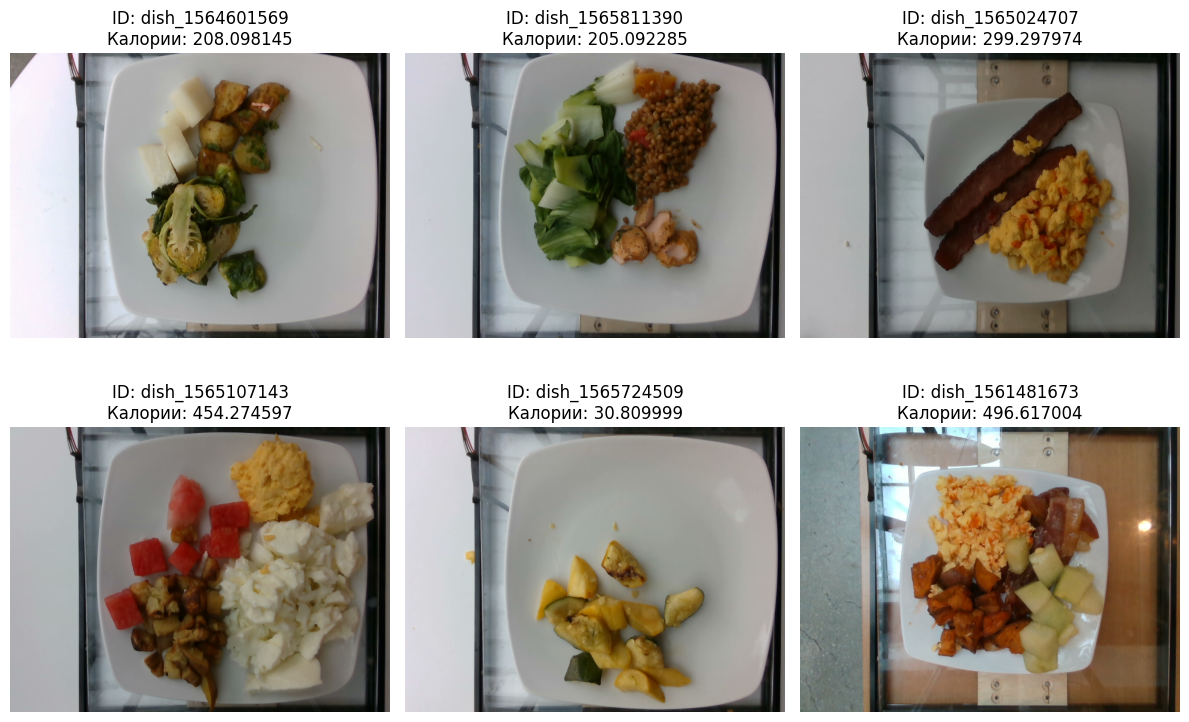

In [14]:
# Изображение и калорийность шести случайных блюд из тренировочной выборки
np.random.seed(config['seed'])
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(6):
    idx = np.random.randint(0, len(df_train))
    dish_id = df_train.iloc[idx]['dish_id']
    img_dir = os.path.join('data/images', dish_id)
    img_files = [f for f in os.listdir(img_dir)]
    img_path = os.path.join(img_dir, img_files[0])
    img = Image.open(img_path)
    row, col = i // 3, i % 3
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'ID: {dish_id}\nКалории: {df_train.iloc[idx]["total_calories"]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Блюда расположены на одной и той же поверхности, но на разной посуде. Заметен недостаток освещения.

Решать задачу будем с помощью мультимодальной нейросети с использованием двух предобученных моделей: EfficientNet-B0 для изображений и paraphrase-MiniLM-L3-v2 для текста. 

Для улучшения обобщающей способности нейросети и повышения устойчивости к естественным изменениям в изображениях блюд проведем аугументацию изображений:
- RandomHorizontalFlip добавит инвариантность к отражению,
- RandomRotation добавит устойчивость к наклону,
- ColorJitter улучшит устойчивость к освещению.

При обучении будем ориентироваться на метрики:
- L1Loss в качестве функции потерь
- Mean absolute error в качестве метрики качества предсказаний модели на валидационной выборке (таргет: < 50)

# Обучение модели (выполнено на ВМ)

In [ ]:
set_seed(config['seed'])

# Загрузка предобученного текстового энкодера
text_encoder = PretrainedTextEncoder(model_name='paraphrase-MiniLM-L3-v2')

# Трансформации
train_transform, val_transform = get_transforms()

# Датасеты
train_dataset = FoodDataset(df_train, config['paths']['img_dir'], text_encoder, transform=train_transform)
val_dataset = FoodDataset(df_test, config['paths']['img_dir'], text_encoder, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

# Модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
final_model = FoodCaloriePredictor(text_encoder).to(device)

# Обучение и валидация
train(config, model, text_encoder, train_loader, val_loader, device)

Epoch 1/10, Train Loss: 115.2026, Val MAE: 78.0194
Epoch 2/10, Train Loss: 83.6876, Val MAE: 65.5569
Epoch 3/10, Train Loss: 78.4121, Val MAE: 65.4284
Epoch 4/10, Train Loss: 74.9862, Val MAE: 55.7229
Epoch 5/10, Train Loss: 62.5587, Val MAE: 55.0536
Epoch 6/10, Train Loss: 56.7651, Val MAE: 57.6948
Epoch 7/10, Train Loss: 53.7993, Val MAE: 57.9993
Epoch 8/10, Train Loss: 50.1979, Val MAE: 49.8590
Цель по MAE достигнута, модель сохранена


# Валидация качества

In [17]:
# Загрузка весов сохраненной модели
text_encoder = PretrainedTextEncoder(model_name='paraphrase-MiniLM-L3-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
final_model = FoodCaloriePredictor(text_encoder).to(device)
final_model.load_state_dict(torch.load(config['model_save_path'], map_location=device))

<All keys matched successfully>

In [ ]:
# Подготовка тестовой выборки (повтор для выполнения не на ВМ)
train_transform, val_transform = get_transforms()
val_dataset = FoodDataset(df_test, config['paths']['img_dir'], text_encoder, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

In [ ]:
# Инференс
final_model.eval()
all_preds = []
all_targets = []
all_dish_ids = []
all_weights = []

with torch.no_grad():
    for images, ingredients, weights, targets in val_loader:
        images, weights, targets = images.to(device), weights.to(device), targets.to(device)
        ingr_embeddings = text_encoder(ingredients).to(device)
        outputs = final_model(images, ingr_embeddings, weights)
        
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_weights.extend(weights.cpu().numpy())

# Фиксируем результаты
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_weights = np.array(all_weights)

# MAE
mae = mean_absolute_error(all_targets, all_preds)

# Вычисляем ошибки для каждого примера
errors_percent = all_targets / all_preds - 1
errors_value = all_preds - all_targets
errors_abs_percent = np.abs(all_targets / all_preds - 1)

# Индексы топ-5 самых больших по модулю относительных ошибок
top5_indices = np.argsort(errors_abs_percent)[-5:][::-1]

MAE тестовой выборки: 49.8590

Топ-5 блюд с наибольшей ошибкой:
1. dish_1562617703
   Ингредиенты: frozen yogurt
   Вес: 110.00 г
   Истинные калории: 179.63
   Предсказанные калории: 65.80
   Ошибка: -113.83
   Ошибка в процентах: 172.99%

2. dish_1566328745
   Ингредиенты: chicken, cherry tomatoes
   Вес: 203.00 г
   Истинные калории: 282.03
   Предсказанные калории: 108.51
   Ошибка: -173.52
   Ошибка в процентах: 159.90%

3. dish_1562617939
   Ингредиенты: chickpeas, salt, mustard greens, olive oil, parsley, vinegar, arugula, pepper
   Вес: 133.00 г
   Истинные калории: 234.97
   Предсказанные калории: 107.41
   Ошибка: -127.55
   Ошибка в процентах: 118.75%

4. dish_1557861216
   Ингредиенты: plate only
   Вес: 1.00 г
   Истинные калории: 0.00
   Предсказанные калории: 25.38
   Ошибка: 25.38
   Ошибка в процентах: -100.00%

5. dish_1558461431
   Ингредиенты: spinach (raw)
   Вес: 5.00 г
   Истинные калории: 1.15
   Предсказанные калории: 12.19
   Ошибка: 11.04
   Ошибка в процента

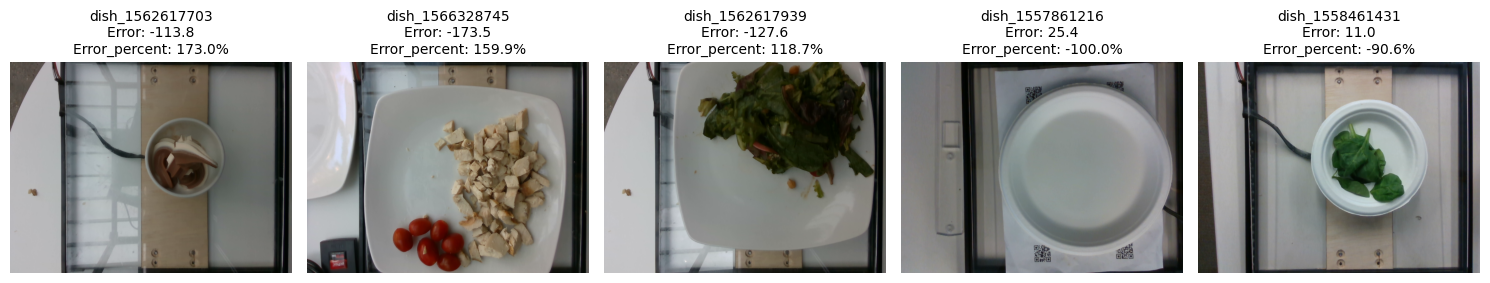

In [37]:
# Вывод результатов
print(f'MAE тестовой выборки: {mae:.4f}')

print('\nТоп-5 блюд с наибольшей ошибкой:')
weight_mean = df_test['total_mass'].mean()
weight_std = df_test['total_mass'].std()
dish_info = []
for i, idx in enumerate(top5_indices):
    dish_id = df_test.iloc[idx]['dish_id']
    true_cal = all_targets[idx]
    pred_cal = all_preds[idx]
    weight = all_weights[idx]
    error_percent = errors_percent[idx]
    error_value = errors_value[idx]
    ingredients = df_test.iloc[idx]['ingr_text']
    
    print(f'{i+1}. {dish_id}')
    print(f'   Ингредиенты: {ingredients}')
    print(f'   Вес: {weight * weight_std + weight_mean:.2f} г')
    print(f'   Истинные калории: {true_cal:.2f}')
    print(f'   Предсказанные калории: {pred_cal:.2f}')
    print(f'   Ошибка: {error_value:.2f}')
    print(f'   Ошибка в процентах: {error_percent:.2%}')
    print()

    dish_info.append({
        'dish_id': dish_id,
        'true_cal': true_cal,
        'pred_cal': pred_cal,
        'error_value': error_value,
        'error_percent': error_percent,
        'ingredients': ingredients,
        'weight': weight
    })

# Визуализация изображений
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, info in enumerate(dish_info):
    dish_id = info['dish_id']
    img_dir = os.path.join(config['paths']['img_dir'], dish_id)
    img_files = [f for f in os.listdir(img_dir)]
    img_path = os.path.join(img_dir, img_files[0])
    
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'{dish_id}\nError: {info["error_value"]:.1f}\nError_percent: {info["error_percent"]:.1%}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Наихудшее предсказание модель выдала для блюда на очень маленькой тарелке. По следующим четырем предсказаниям можно сделать вывод о том, что модель плохо предсказывает калорийность блюд, которые занимают не всю поверхность тарелки.